In [53]:
import numpy as np
import shapely.geometry
import pyproj
import UsefulFunctions as uf
import pygmt
import pandas as pd
import xarray as xr

In [71]:
latN = 72
latS = 49.5
lonW = 164
lonE = -129
stations = pd.read_csv('Data/EEWNetwork.csv')
stepsize = 1*1000 # 5 km grid step size


In [72]:

# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857')
to_original_transformer = pyproj.Transformer.from_crs('epsg:3857', 'epsg:4326')


# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((latS, lonW))
ne = shapely.geometry.Point((latN, 180))

# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform SW point to 3857
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for NE
print(sw)
print(transformed_sw)
print(ne)
print(transformed_ne)

# Iterate over 2D area
gridpoints = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        p = shapely.geometry.Point(to_original_transformer.transform(x, y))
        gridpoints.append(p)
        y += stepsize
    x += stepsize

print(len(gridpoints))
latsW = np.array([p.x for p in gridpoints])
lonsW = np.array([p.y for p in gridpoints])


POINT (49.5 164)
(18256396.490096867, 6360130.74092142)
POINT (72 180)
(20037508.342789244, 11753184.615338452)
9612108


In [73]:
# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857')
to_original_transformer = pyproj.Transformer.from_crs('epsg:3857', 'epsg:4326')

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((latS, -180))
ne = shapely.geometry.Point((latN, lonE))

# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform SW point to 3857
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for NE
print(sw)
print(transformed_sw)
print(ne)
print(transformed_ne)

# Iterate over 2D area
gridpoints = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        p = shapely.geometry.Point(to_original_transformer.transform(x, y))
        gridpoints.append(p)
        y += stepsize
    x += stepsize

print(len(gridpoints))
latsE = np.array([p.x for p in gridpoints])
lonsE = np.array([p.y for p in gridpoints])


POINT (49.5 -180)
(-20037508.342789244, 6360130.74092142)
POINT (72 -129)
(-14360214.31233229, 11753184.615338452)
30627132


In [74]:
grid_lats = np.hstack((latsW, latsE))
grid_lons = np.hstack((lonsW, lonsE))
print(grid_lats.shape)

(40239240,)


/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/

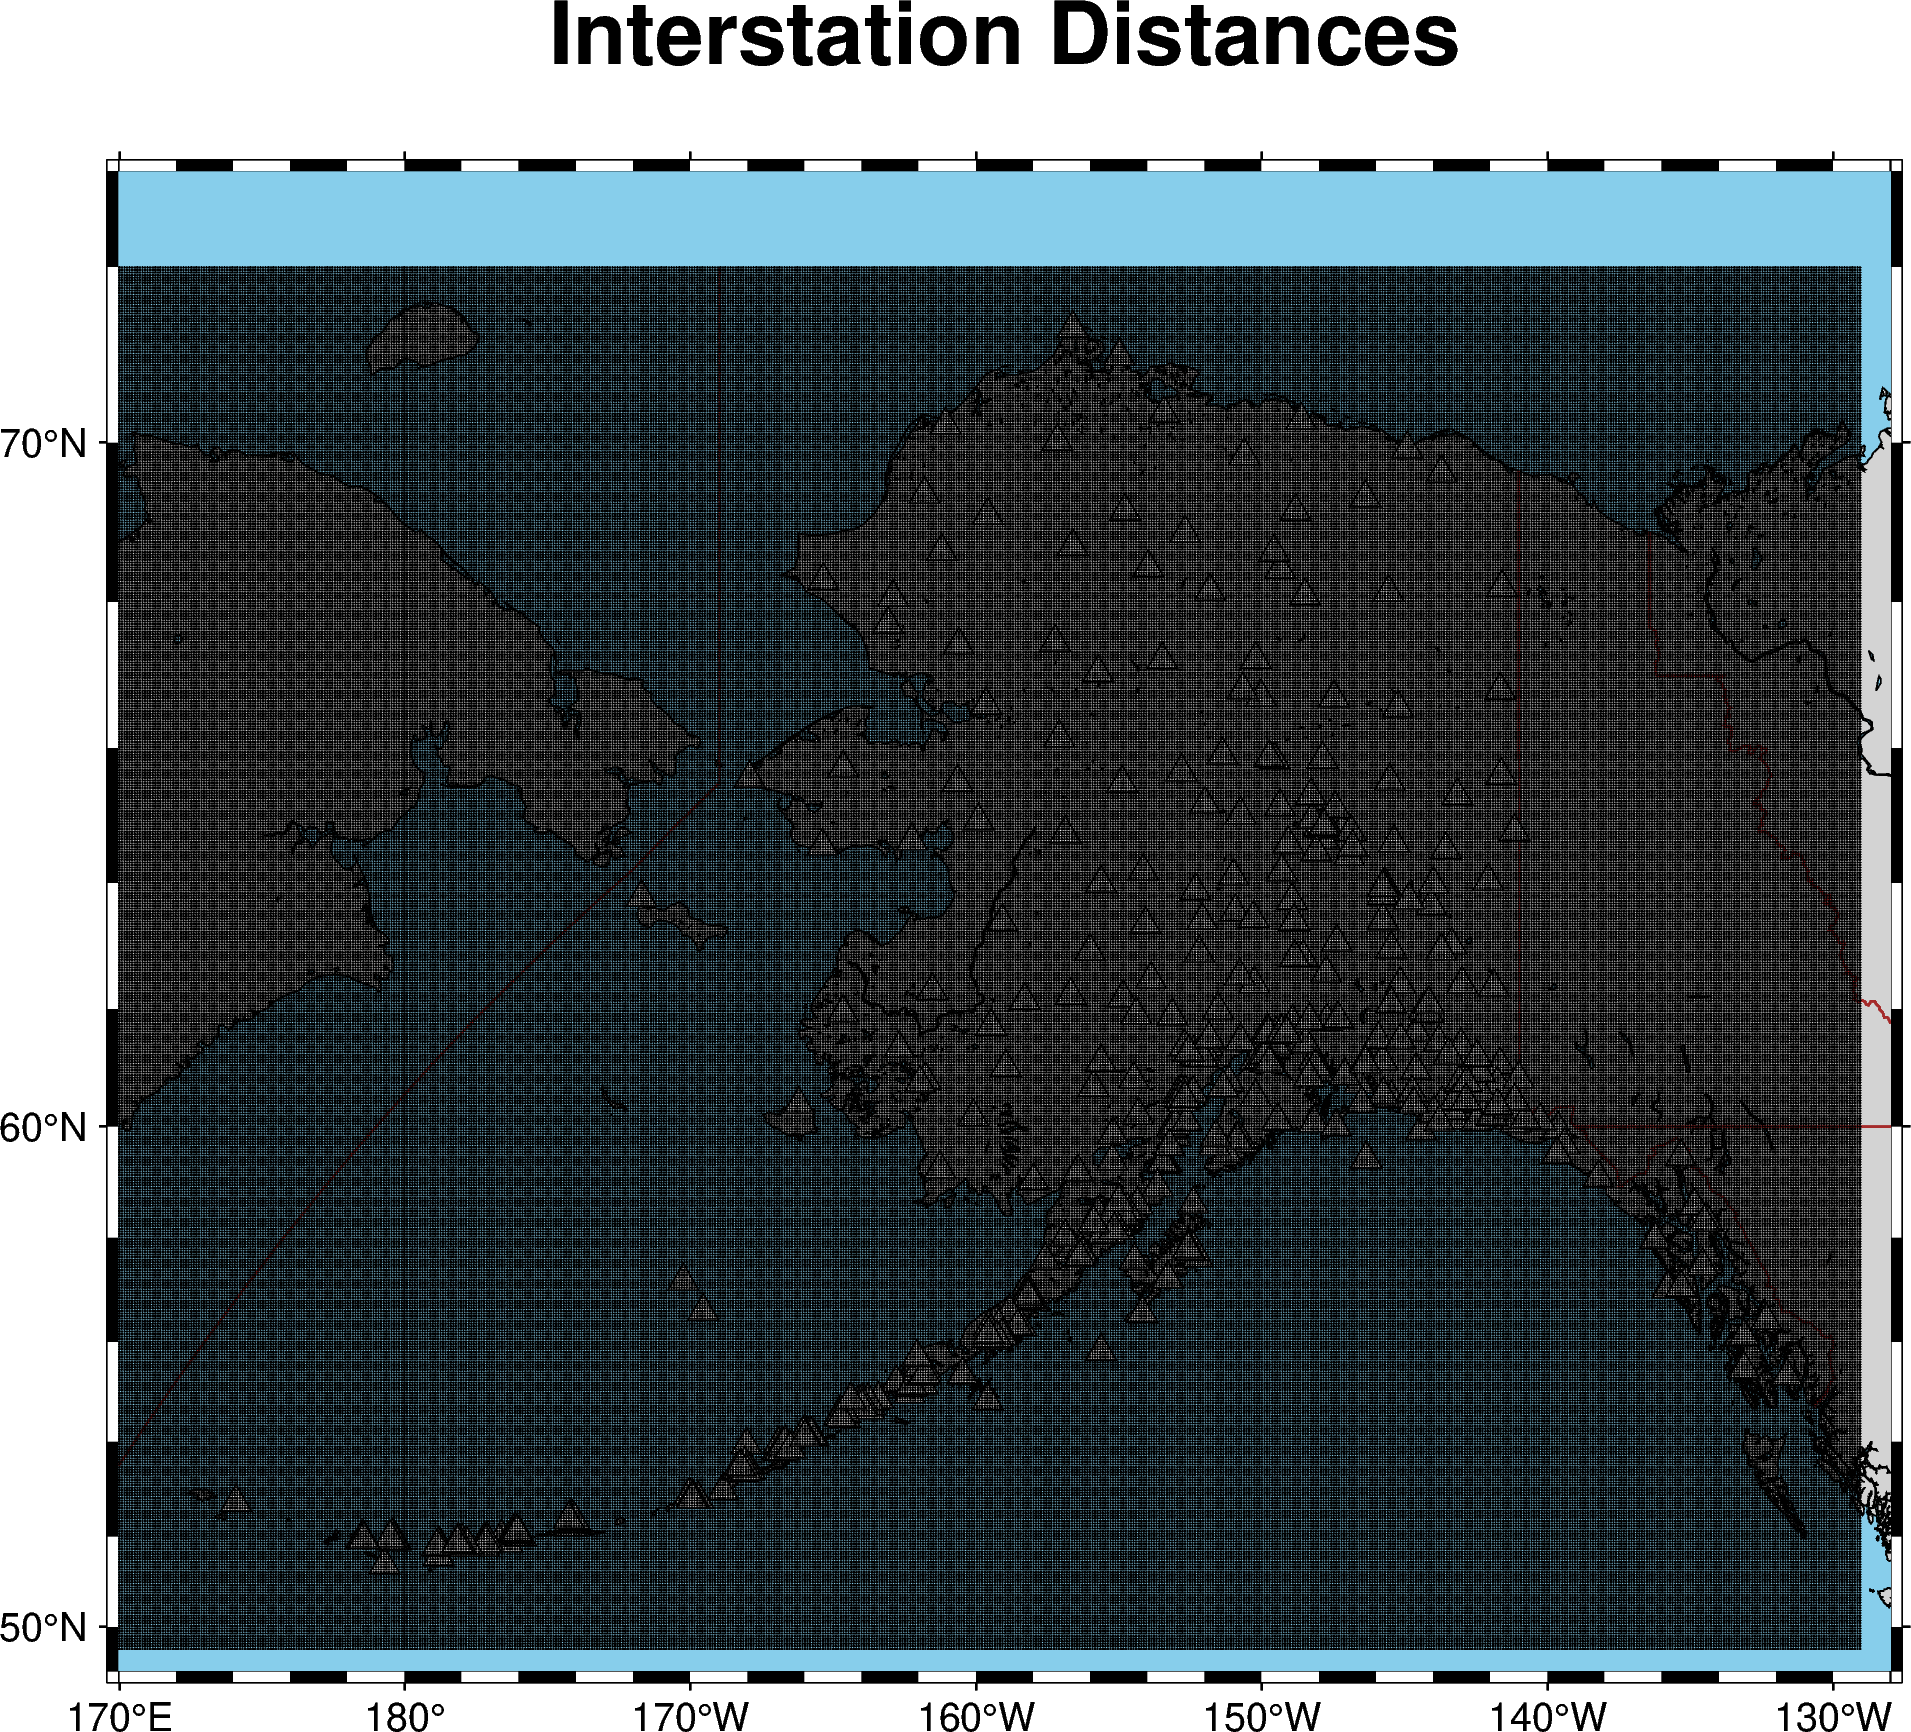

/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory


In [58]:
gridBoundaries = [lonW-1, lonE+1, latS-1, latN+1]
title = r"Interstation Distances"
coast_border = "a/0.5p,brown"
shorelines = "0.3p,black"
fig = pygmt.Figure()
fig.basemap(region='170/49/-128/73+r', projection='M15c', frame=["af", f'WSne+t"{title}"'])
fig.coast(shorelines=shorelines, borders=coast_border, water='skyblue', land='lightgray')  # draw coast over datawater='skyblue'

pygmt.makecpt(
    transparency=75,
    cmap=['seis'],
    reverse=True,
    series=[0, 60]  # np.max(p[2, :])
)
fig.plot(  # Plot seismic stations as triangles
    x=stations['Lon'],
    y=stations['Lat'],
    style='t+0.3c',
    color='white',
    pen='black',
)
fig.plot(
    x=grid_lons,
    y=grid_lats,
    style='c+0.0025c',
    )
fig.show()
fig.savefig('Figures/misc/interstationdist_grid.pdf')

In [59]:
sta_lats = np.array(stations['Lat'])
sta_lons = np.array(stations['Lon'])
print(np.array(stations['Lon']).shape)
num_p = len(grid_lons)
num_sta = len(sta_lons)
grid_lons_2D = np.reshape(grid_lons, (num_p, 1))
grid_lats_2D = np.reshape(grid_lats, (num_p, 1))

sta_lons_2D = np.zeros(shape=(num_p, num_sta))
sta_lats_2D = np.zeros(shape=(num_p, num_sta))
for i in range(num_p):
    sta_lons_2D[i,:] = sta_lons
    sta_lats_2D[i,:] = sta_lats
print(grid_lons_2D.shape)
print(sta_lons_2D.shape)

(504,)
(403380, 1)
(403380, 504)


In [60]:
a = np.array([[1, 2, 3], [4, 5, 6], [7,8,9]])
b = np.array([1,2,3])
print(a)
print(b)
print(a-b[:,None])
print(a*a)
print(a/2)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[1 2 3]
[[0 1 2]
 [2 3 4]
 [4 5 6]]
[[ 1  4  9]
 [16 25 36]
 [49 64 81]]
[[0.5 1.  1.5]
 [2.  2.5 3. ]
 [3.5 4.  4.5]]


In [61]:
r = 6371  # Radius of earth in km
phi1 = np.radians(grid_lats)
phi2 = np.radians(sta_lats_2D)
dphi = np.radians(sta_lats_2D - grid_lats[:,None])
dlambda = np.radians(sta_lons_2D - grid_lons[:,None])
a = (np.sin(dphi / 2)) ** 2 + np.cos(phi1)[:,None] * np.cos(phi2) * (np.sin(dlambda / 2)) ** 2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
d = r * c  # distance in km


In [62]:
mindex = d[0,:].argmin()
print(d.shape)
print(mindex)
print(sta_lons[mindex], sta_lats[mindex])
print(grid_lons[0], grid_lats[0])
nearest_sta_dist = d.min(axis=1)
print(nearest_sta_dist.min())

(403380, 504)
440
174.1031 52.7308
164.0 49.5
0.13565726905804787


In [ ]:
anc_nlon = anc.grid_spec['nlon']
anc_nlat = anc.grid_spec['nlat']
anc_lons_single = anc.lons[:anc_nlon].flatten()
anc_lats_single = anc.lats[::anc_nlon].flatten()
data = anc.mmi.reshape((anc_nlat, anc_nlon))
grid = xr.DataArray(
    data=data,
    dims=['lat', 'lon'],
    coords=dict(
        lon=(['lon'], anc_lons_single),
        lat=(['lat'], anc_lats_single)
    )
)

/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/

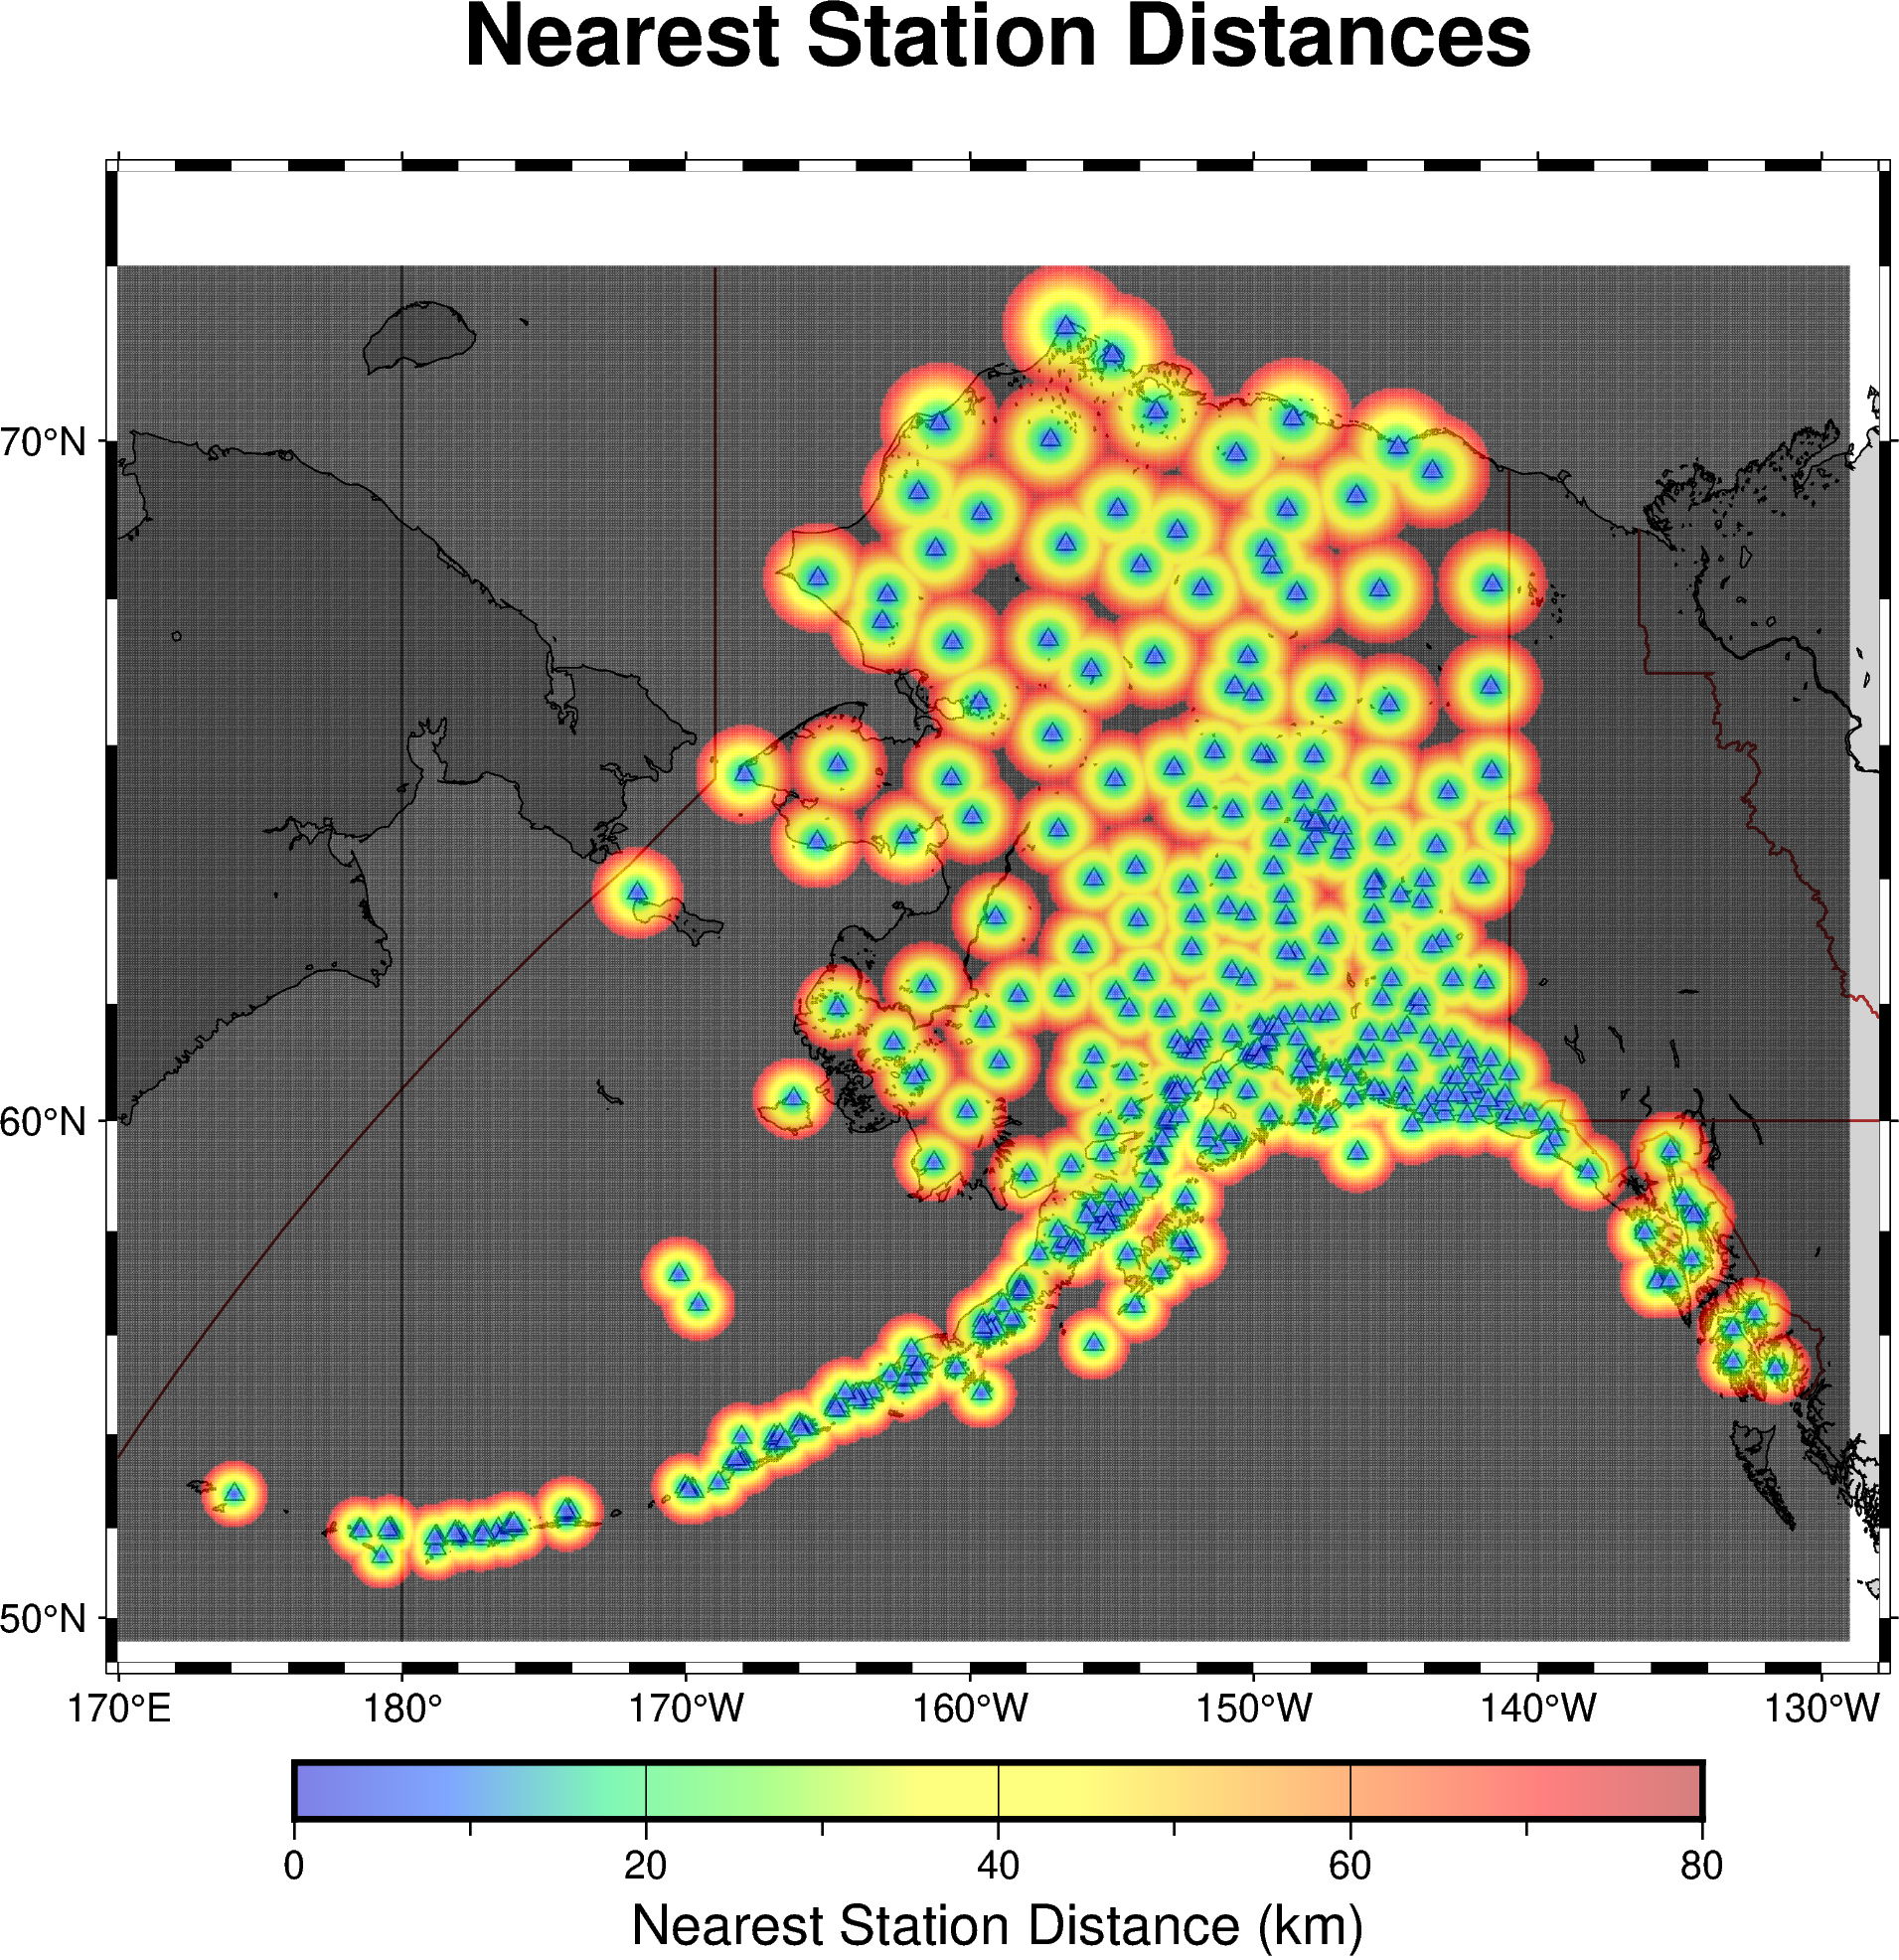

/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory
/usr/local/gmt/bin/gmt: line 168: /usr/local/gmt_all/gmt-4.5.3/bin/--show-library: No such file or directory


In [69]:
title = r"Nearest Station Distances"
coast_border = "a/0.5p,brown"
shorelines = "0.3p,black"
fig = pygmt.Figure()
fig.basemap(region='170/49/-128/73+r', projection='M15c', frame=["af", f'WSne+t"{title}"'])
fig.coast(shorelines=shorelines, borders=coast_border, water='white', land='lightgray')  # draw coast over datawater='skyblue'

pygmt.makecpt(
    transparency='70+a',
    cmap=['seis'],
    reverse=True,
    series=[0, 80]  # np.max(p[2, :])
)
fig.plot(  # Plot seismic stations as triangles
    x=stations['Lon'],
    y=stations['Lat'],
    style='t+0.2c',
    color='white',
    pen='black',
)
fig.plot(
    x=grid_lons,
    y=grid_lats,
    color=nearest_sta_dist,
    cmap=True,
    style='c+0.0025c',
    )
fig.colorbar(frame='xafg20+l"Nearest Station Distance (km)"')

fig.show()
fig.savefig('Figures/misc/interstationdist.pdf')